# Seeing Calculations

This notebook does takes a set of images from MCS and
  #1 plots a few basic image diagnostics
  #2 does the centroiding on all the images
  #3 calculates an approximate transformation from the pinhole mask to the image
  #4 applies this to the mask
  #5 registers the centroids in each frame to the mask
  #6 calculates the average of the centroid parameters by position
  #7 calculates the RMS of the spot position (- the average of the frame), compared to the average position
  #8 calculates the translation and scaling for each frame, relative to the mask




In [1]:
#import statements

%matplotlib notebook

#import statements
import vis_plotting as visplot        #plotting routines 
import vis_calculations as viscalc    #calculation routines
import vis_coordinates as viscoords   #routines related to coordinate transforms
import numpy as np
from importlib import reload  #for debugging purposes
import matplotlib.pylab as plt




In [39]:
#set parameters for centroiding. These are needed if you're running the centroiding locally. 

#basic parameters - threshold probably needs to be tuned it should be 
#above the background but below the lowest peak value. 
fwhm=3        
boxsize=9
thresh=2500

#shape parameters for centroiding. If the points are not circular,
#rl and rh may need to be changed; -1, 1 are the values for a circular
#psf. sl and sh should probably not need to be changed

rl=-2.5
rh=1.3
sl=0.05
sh=0.5

#plotting flag, this lets the same code be used for the notebook and for non-interactive 
#scripts

inter=1


# Connect to Database

In [ ]:
try:
    file = open("/Users/chyan/Documents/workspace/ics_mcsActor/etc/dbpasswd.cfg", "r")
    passstring = file.read()
    print('text="Password reading OK. value = %s."'%(passstring))
except:
    print('text="could not get db password"')

try:
    conn = psycopg2.connect("dbname='fps' user='pfs' host='133.40.164.208' password="+passstring)
    print('text="Connected to FPS database."')
except:
    print('text="I am unable to connect to the database."')
    
    

# Retrieve a set of centroids from the database.

We need a list of the relevant identification numbers. 

In [ ]:

#get set of centroids from database. Change idList to the files you want. 

idList=[1,2,3,4]

#frameId = 209
#moveId = 1

#make a blank array for the centroid array
centroids=np.array([])

#and for the list of files
filenames=[]

i=0


#cycle through each ID number
for id in idList:
    
    #SQL for getting a set of centroids
    cmd_string = f"""select * from mcsEngTable where frameId={id}"""

    data=np.array([]) 
    n = 0
    with conn.cursor() as curs:
            curs.execute(cmd_string)
            rows=curs.fetchall()
            for idx, val in enumerate(rows):
                if idx == 0: data = val 
                if idx != 0: data = np.vstack([data,val])
    conn.commit()

    cen=data[:,4:11]
    
    #some data massaging so that it's in the right form.
    #first, add an index number for the run to the first column
    cen1=np.insert(cen,i,1)
    #then append to the master array. The result is a large arrays of values, 
    #which can be filtered by the id in the first column. 
    centroids=np.concatenate((centroids,cen1),axis=0)
    
    ####??? READ IN THE FILE NAMES HERE and add to the list
    fname=???
    filenames.append()
    
    

# Data IO

This is for reading a set of file names from a file, rather than the database. 

In [91]:

#read in list of files (to be replaced by proper IO)
#filelist="fileset.dat"
filelist="basement_10s_flat1s.dat"

files = [line.rstrip('\n') for line in open(filelist)]
nfiles=len(files)
print("Read "+str(len(files))+" files names.")

#set filenames for saving intermediate steps
tag = "basement01_f2"  # a tag for writing to files or plots
centroidFile=tag+"_centroids.dat"    #file containing centroid


Read 30 files names.


# Get reference image for the datbase case

In [ ]:

#for the database case, get the first set of centroids for the approximate transformation
#estimate

ind=where(centroids[:,0]==0)
xlast=centroids[ind,1]
ylast=centroids[ind,2]



# Sanity Check

As a basic check of data quality, the mean and RMS values of each image are plotted. Note that this is for the pixel values, *not* the spot values. 


MCST_010_001_f.fits


<IPython.core.display.Javascript object>


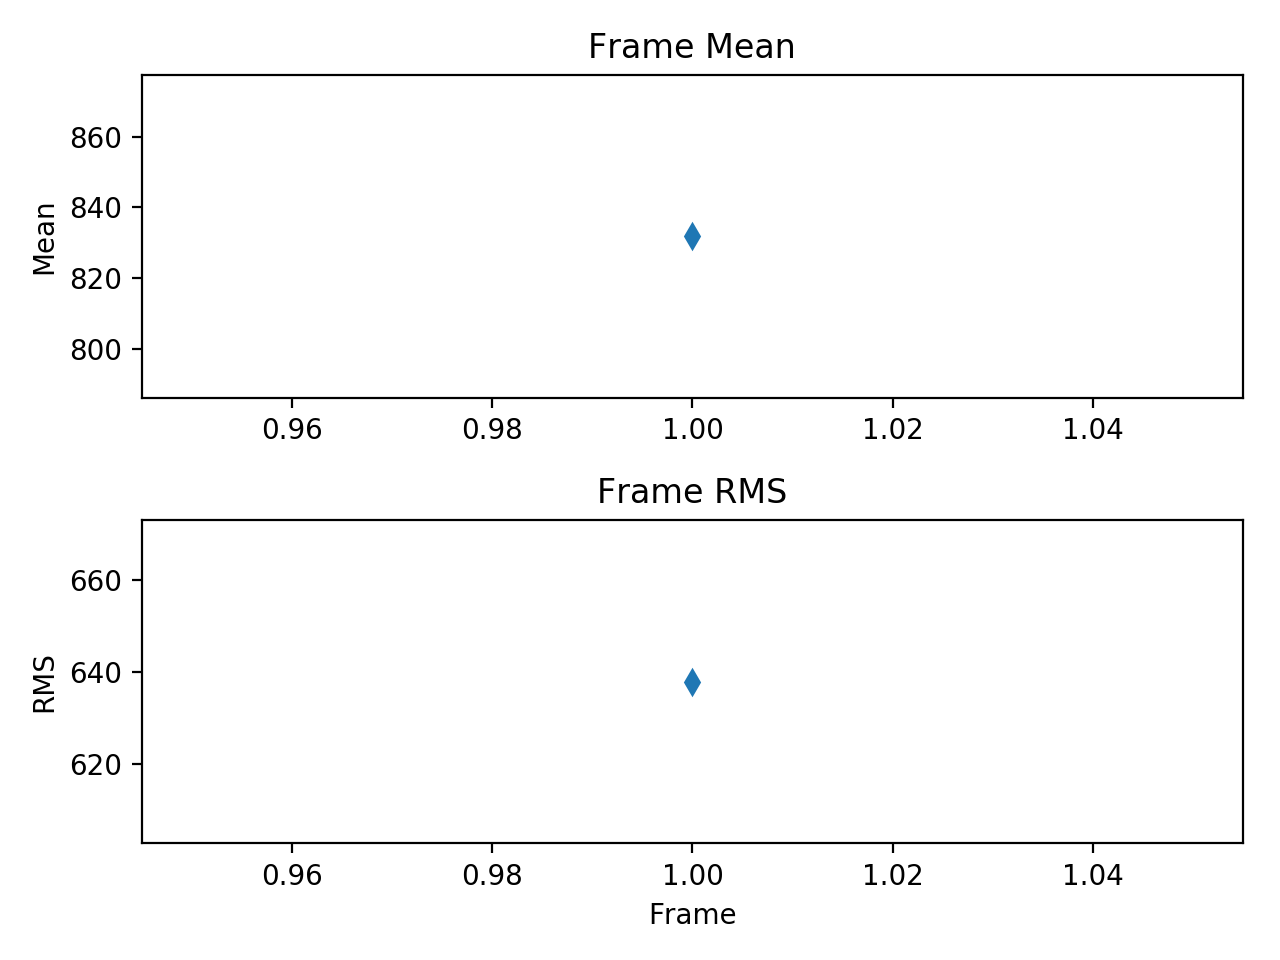

In [43]:
# some basic diagnostic plots
reload(visplot)
visplot.checkPlots(files,inter)


# Centroiding

This is the same as in the visualization tool, but running in a loop to calculate centroids for each frame, and writing the results to a file.  Do this if you aren't extracting values from the database. 

In [92]:

#do the centroiding. 
reload(viscalc)
xlast,ylast=viscalc.getAllCentroids(files,fwhm,boxsize,thresh,rl,rh,sl,sh,centroidFile)
centroids=np.loadtxt(centroidFile)

30 Frames. Centroiding 1, found 3577 centroids, 2, found 3576 centroids, 3, found 3576 centroids, 4, found 3576 centroids, 5, found 3577 centroids, 6, found 3575 centroids, 7, found 3576 centroids, 8, found 3576 centroids, 9, found 3576 centroids, 10, found 3576 centroids, 11, found 3576 centroids, 12, found 3577 centroids, 13, found 3577 centroids, 14, found 3576 centroids, 15, found 3572 centroids, 16, found 3573 centroids, 17, found 3576 centroids, 18, found 3576 centroids, 19, found 3577 centroids, 20, found 3576 centroids, 21, found 3576 centroids, 22, found 3576 centroids, 23, found 3515 centroids, 24, found 3572 centroids, 25, found 3565 centroids, 26, found 3573 centroids, 27, found 3577 centroids, 28, found 3576 centroids, 29, found 3573 centroids, 30, found 3576 centroids, 


# Estimate mask to pixel transformation

From here on, the analysis in the same whether working with local files or the database. 

In [93]:
#get the approximate transformation (good enough for registration) with 
#the last set of x-y coordinates. This includes the mm-to-pixel transformation. 

reload(viscoords)

xm,ym,xd,yd,theta,scale = viscoords.getApproximateTransform(xlast,ylast,1)
print("Transform: xd="+str(xd)+" yd="+str(yd)+" theta="+str(theta)+" scale="+str(scale))


Transform: xd=4439.65344207 yd=2892.67436353 theta=1.56219621112 scale=14.6915577784


# Spot Registration

30 frames. Matching 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 


<IPython.core.display.Javascript object>


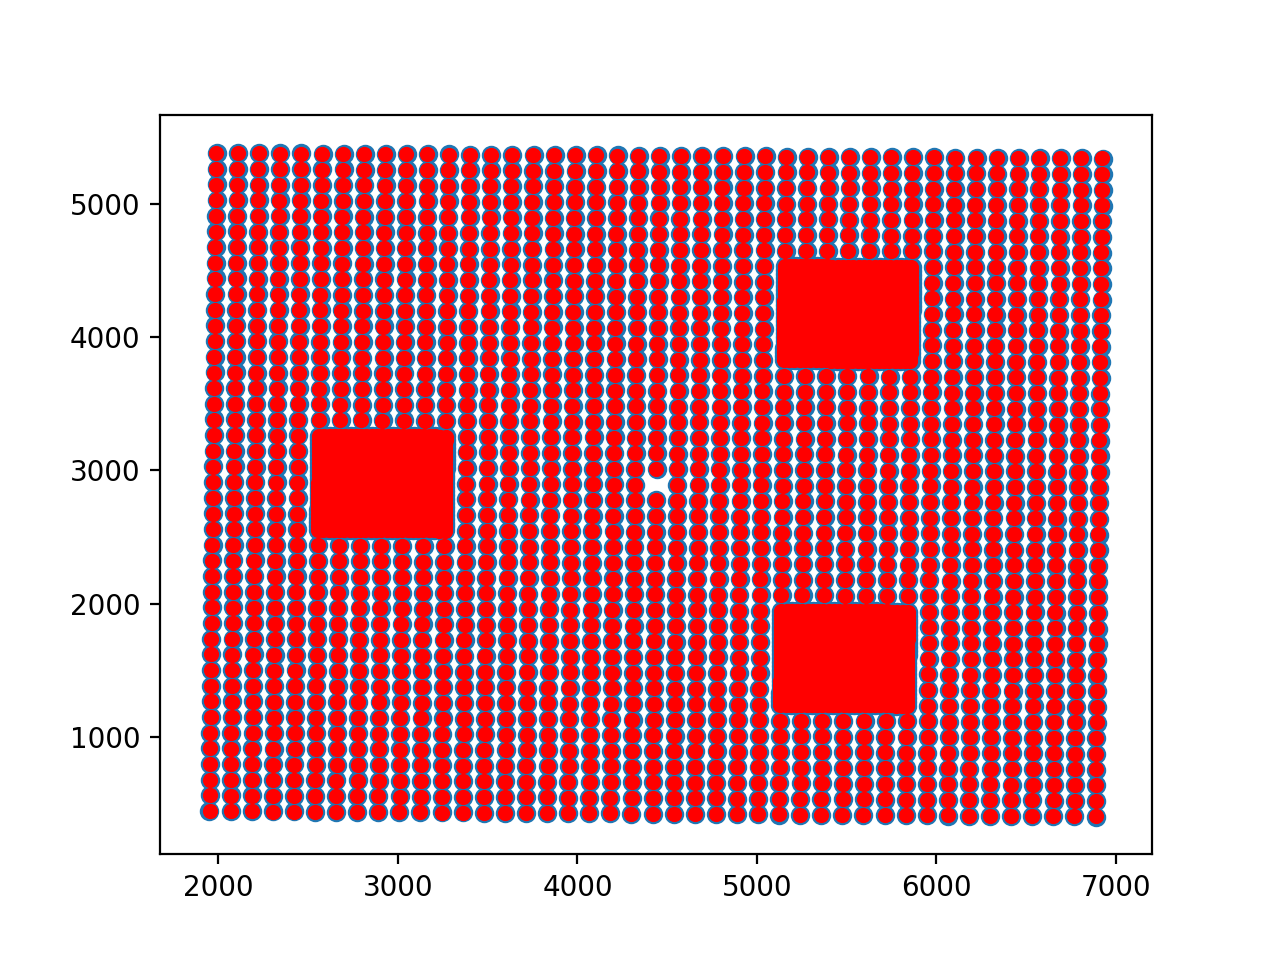

In [94]:
reload(viscoords)

#do the matching. If a point isn't matched to the mask, it will masked via 
#numpy masked arrays.
#The result is a set of data cubes of size npoints x nframes
#display the match for the first frame. 

xArray,yArray,fxArray,fyArray,backArray,peakArray = viscoords.matchAllPoints(centroids,xm,ym)
visplot.checkMatched(xArray[:,0],yArray[:,0],xm,ym,tag,inter)


# Simulated Data

For demonstration purposes, as a set of data for seeing calculations is quite large. 


In [97]:
reload(viscalc)
#make fake data for plotting (because 1 set of data is ~3GB)

#nframes = 30
#avRMS = 0.5
#avShift = 2
#avScale = 1
#avRot = 0
#xArray,yArray,fxArray,fyArray,backArray,peakArray, xm, ym = viscalc.makeFakeCentroids(nframes,avRMS,avShift,avRot,avScale)
#visplot.checkMatched(xArray[:,0],yArray[:,0],xm,ym,tag)



<module 'vis_calculations' from '/Users/karr/ics_mcsActor/python/mcsActor/Visualization/vis_calculations.py'>

# Calculate Averages and RMS

In [98]:
reload(viscalc)
#calculate RMS and write to file

xAv,yAv,fxAv,fyAv,peakAv,backAv,rmsVal,nMatch = viscalc.getRMSStats(xArray,yArray,fxArray,fyArray,peakArray,backArray)


0.0237571249876 0.0419658597335
-0.0120037023027 0.0185654212052
-0.0340283874789 0.171785415585
0.0366835885698 0.0875651083786
0.0774688019227 0.0321866226035
-0.0202760040002 0.0699007130917
-0.0191605406416 -0.0494903413496
0.0295455601386 0.182181399324
0.0907944703008 -0.00717334543402
0.0629442666319 0.0279349131071
0.0383239087543 -0.049214151766
0.0445898091095 0.036537605776
-0.000243289735592 0.0837932976532
0.0531358311509 -0.0844156376614
-0.0337006121761 0.0901976086261
-0.0583441843879 0.106857435759
-0.0209560051327 0.0664497529203
0.0136666357398 -0.0152745202889
-0.0468921319587 0.0056839687251
-0.0316635926578 -0.101448464054
0.000290737202334 -0.0270656384268
0.0514989249792 0.0184345509463
-0.0176570171659 -0.198113386141
-0.0307634310004 -0.130128182857
-0.0248292843997 -0.172434746329
-0.0630297103303 0.0387063441298
-0.052956354386 -0.0379820355168
-0.0461055620902 -0.110981989107
-0.0399687921591 -0.0182415448112
0.0292882377029 -0.0806102087769


# Plots

#1 Plot of RMS as a function of position
#2 Plot of number of points sucessfully matched (of N frames)
#3 Plot of average FWHM (x) by position
#4 Plot of average FWHM (x) by position

<IPython.core.display.Javascript object>


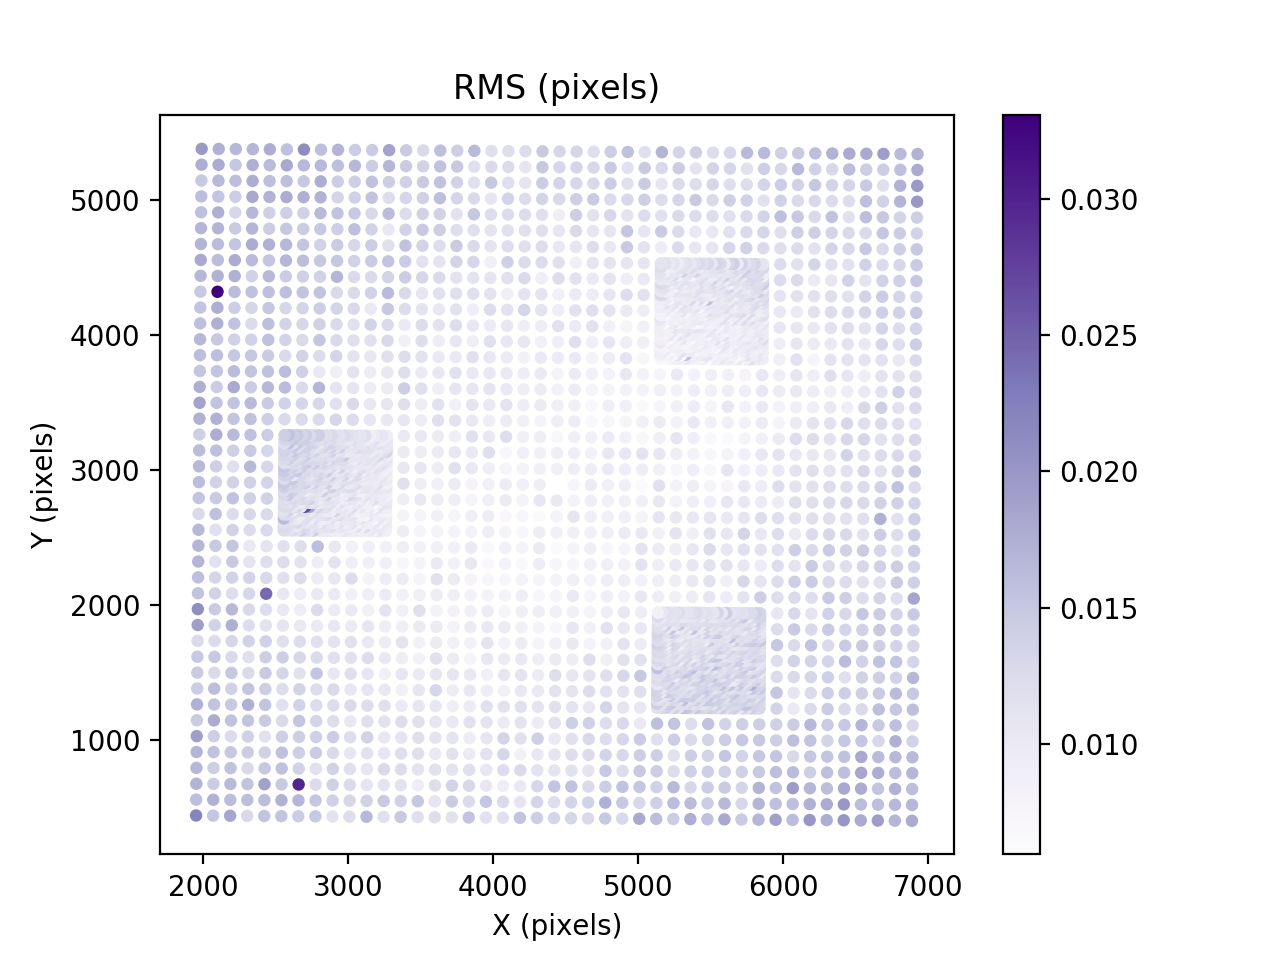

<IPython.core.display.Javascript object>


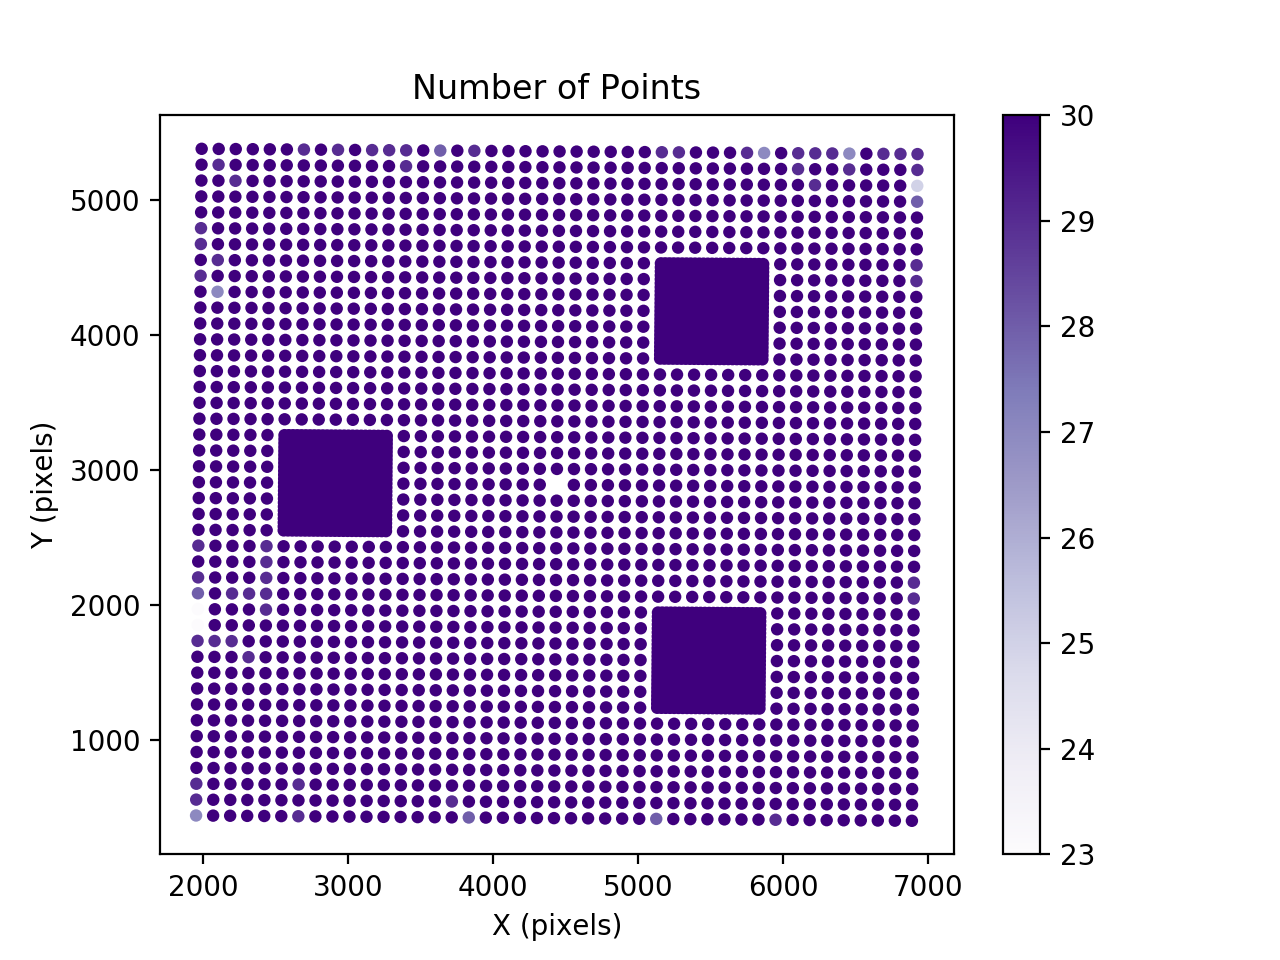

<IPython.core.display.Javascript object>


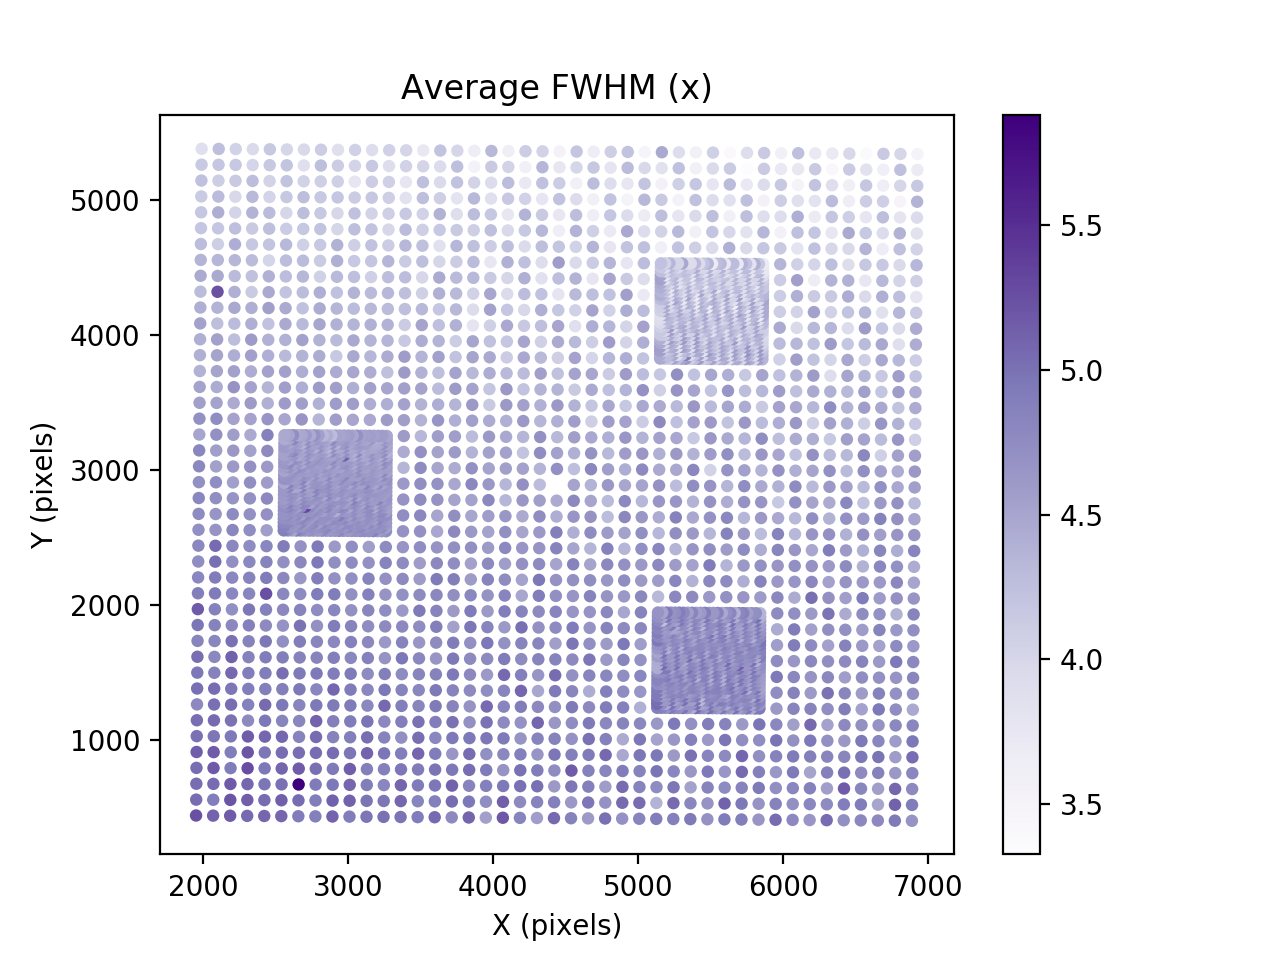

<IPython.core.display.Javascript object>


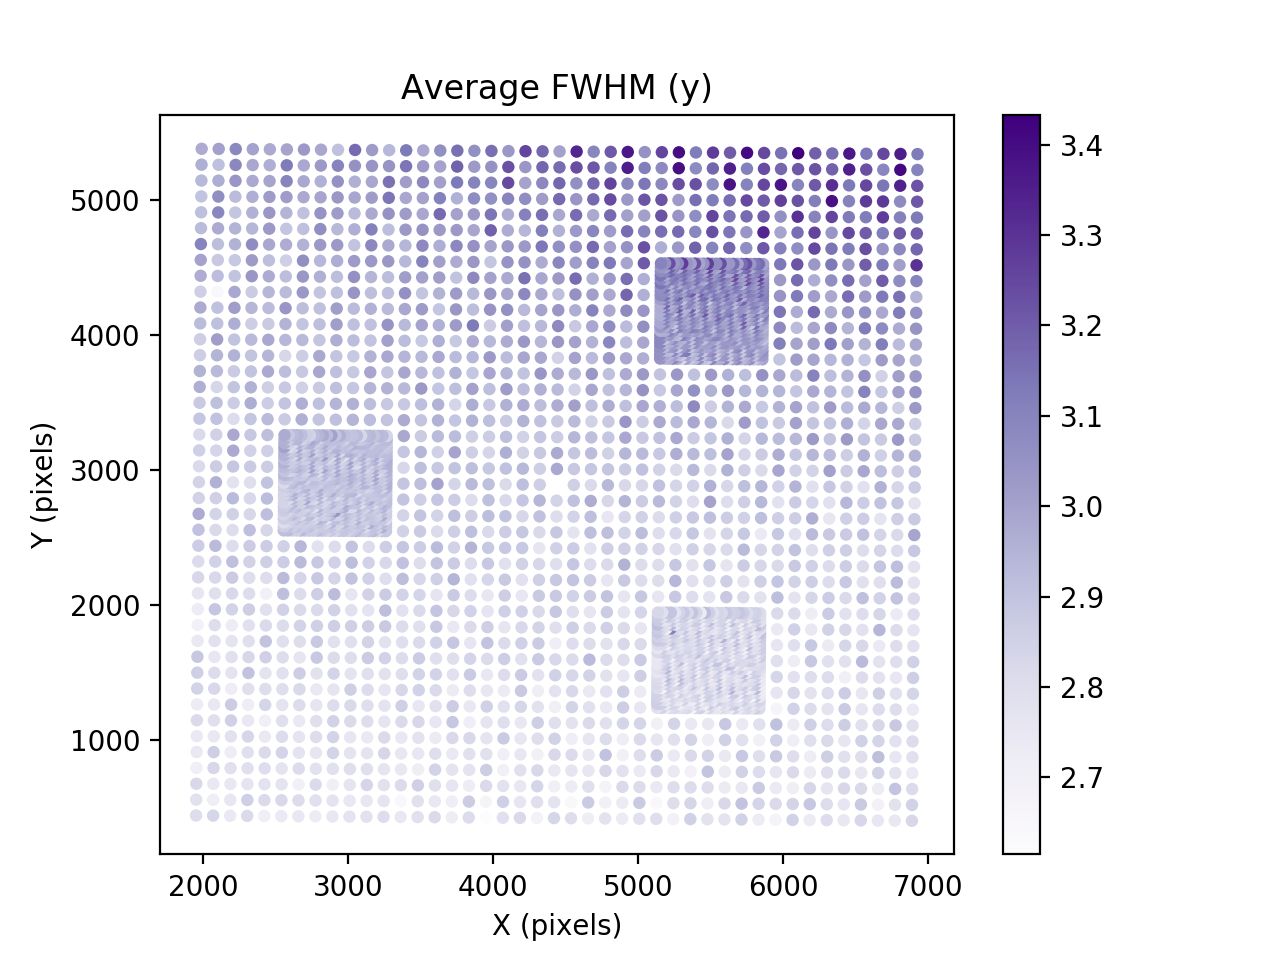

In [99]:
reload(viscalc)
reload(visplot)

plotrange=None
prefix=tag
visplot.plotVal(xAv,yAv,rmsVal,0,plotrange,"RMS (pixels)",prefix,"rms",'pixels',inter)
visplot.plotVal(xAv,yAv,nMatch,0,plotrange,"Number of Points",prefix,"npoints",'pixels',inter)
visplot.plotVal(xAv,yAv,fxAv,0,plotrange,"Average FWHM (x)",prefix,"_fwhmxav",'pixels',inter)
visplot.plotVal(xAv,yAv,fyAv,10,plotrange,"Average FWHM (y)",prefix,"_fwhmyav",'pixels',inter)



In [100]:
reload(viscalc)
reload(viscoords)
#get transformation by frame


xdAll,ydAll,sxAll,syAll,rotAll,fxFrameAv,fyFrameAv,peakFrameAv = viscalc.getTransByFrame(xArray,yArray,fxArray,fyArray,peakArray,xm,ym)


<IPython.core.display.Javascript object>


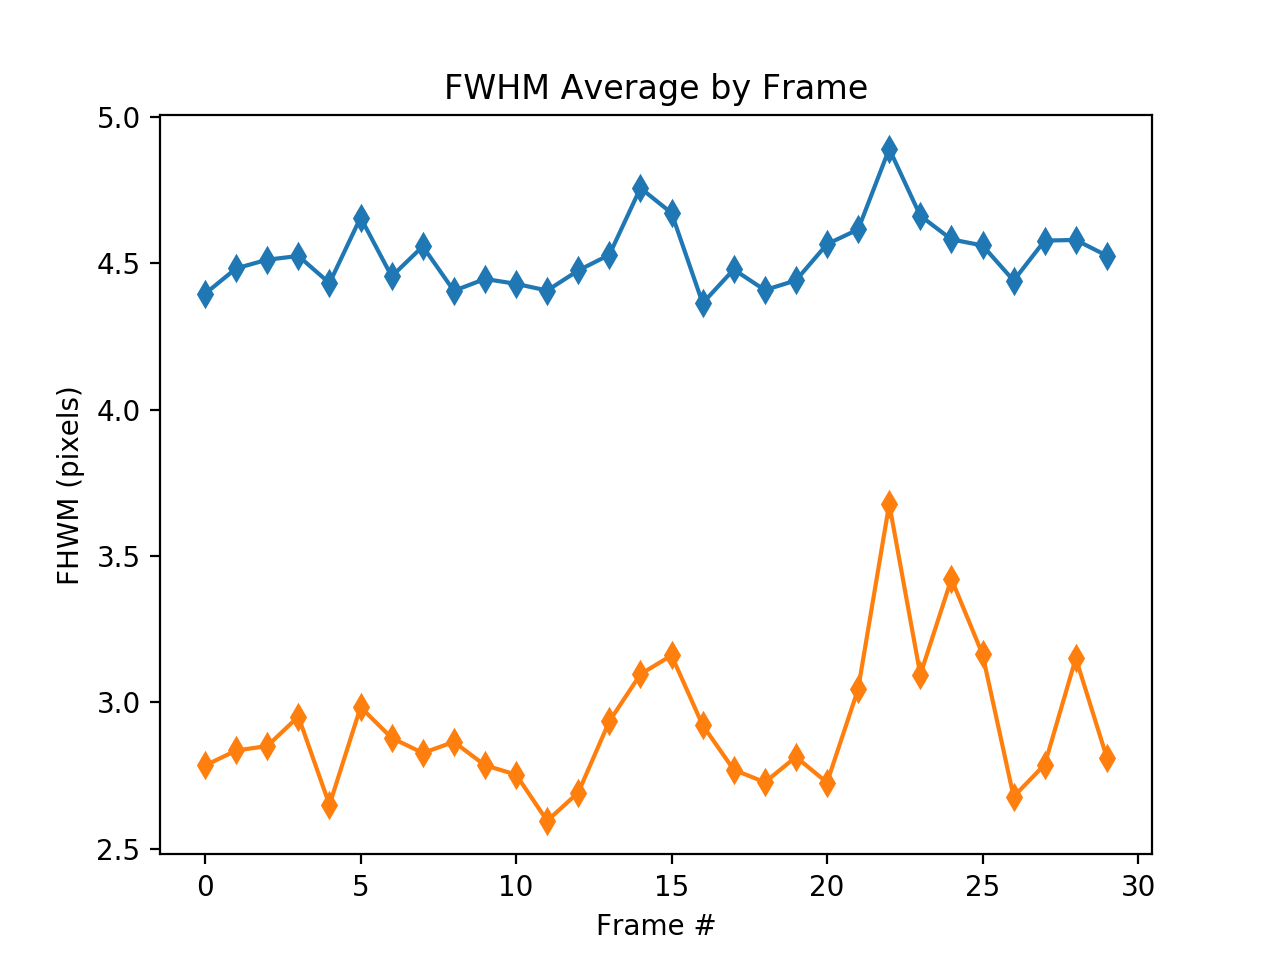

<IPython.core.display.Javascript object>


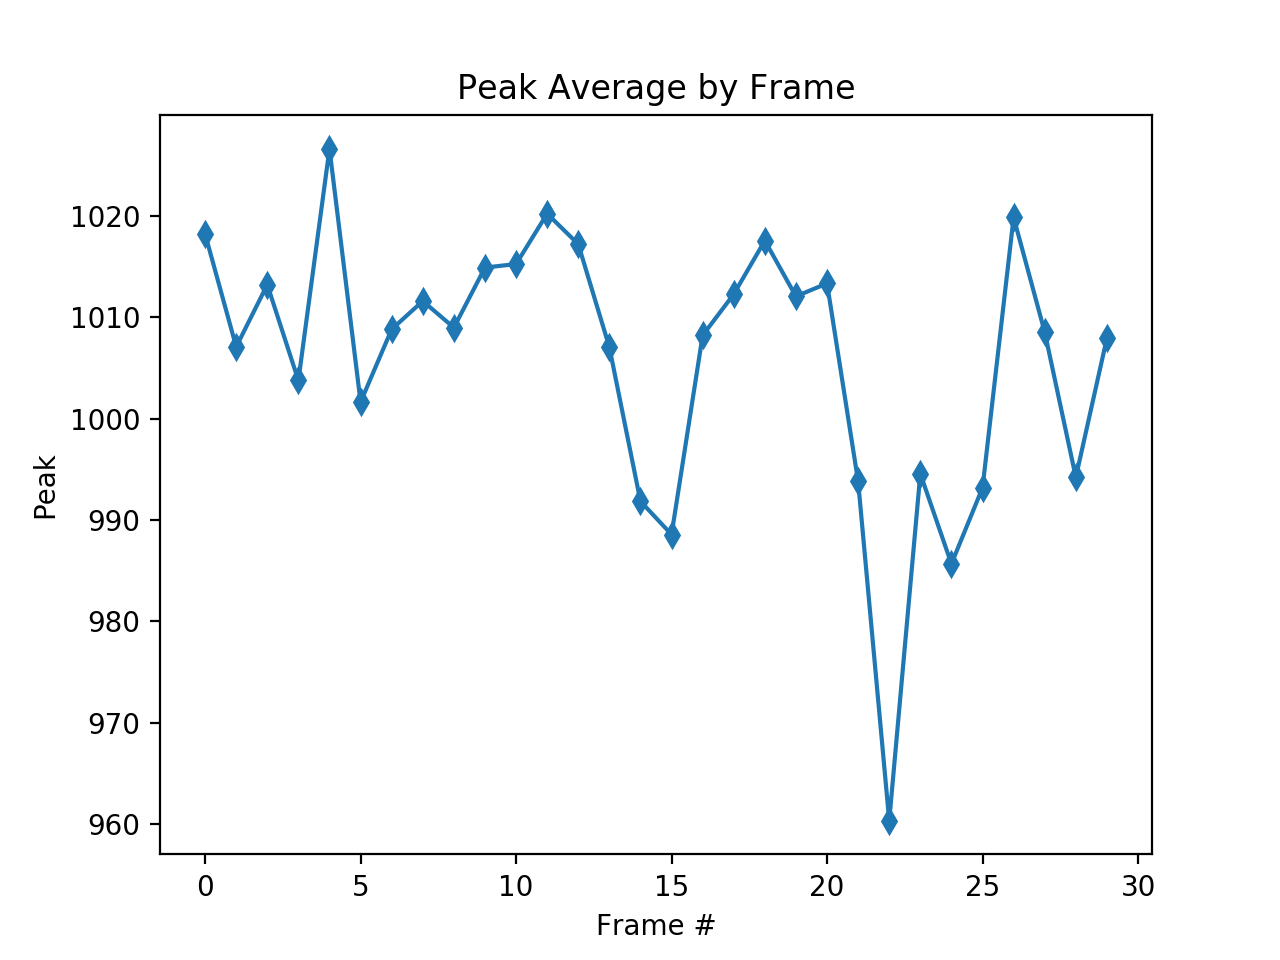

<IPython.core.display.Javascript object>


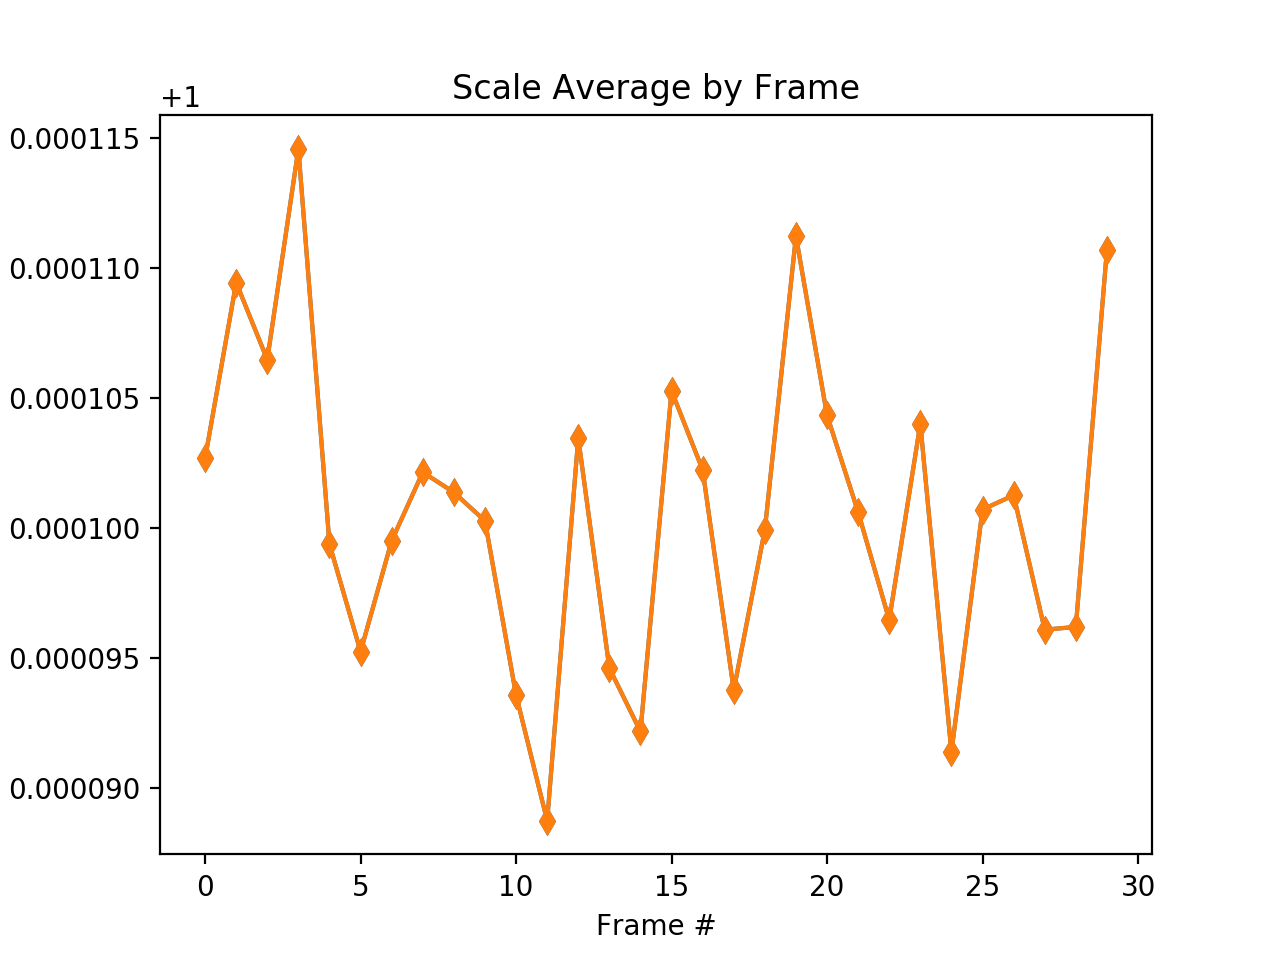

<IPython.core.display.Javascript object>


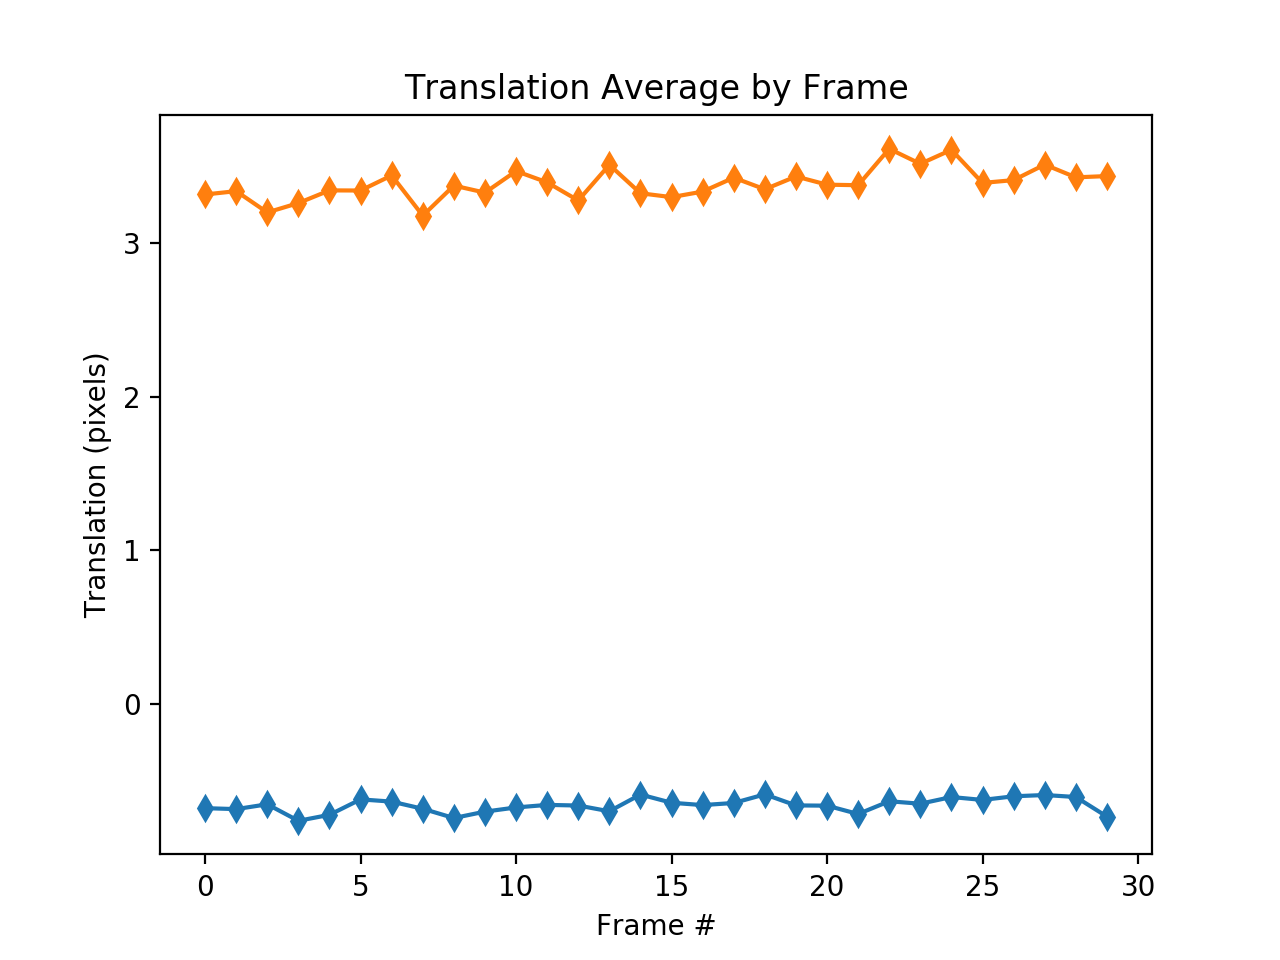

<IPython.core.display.Javascript object>


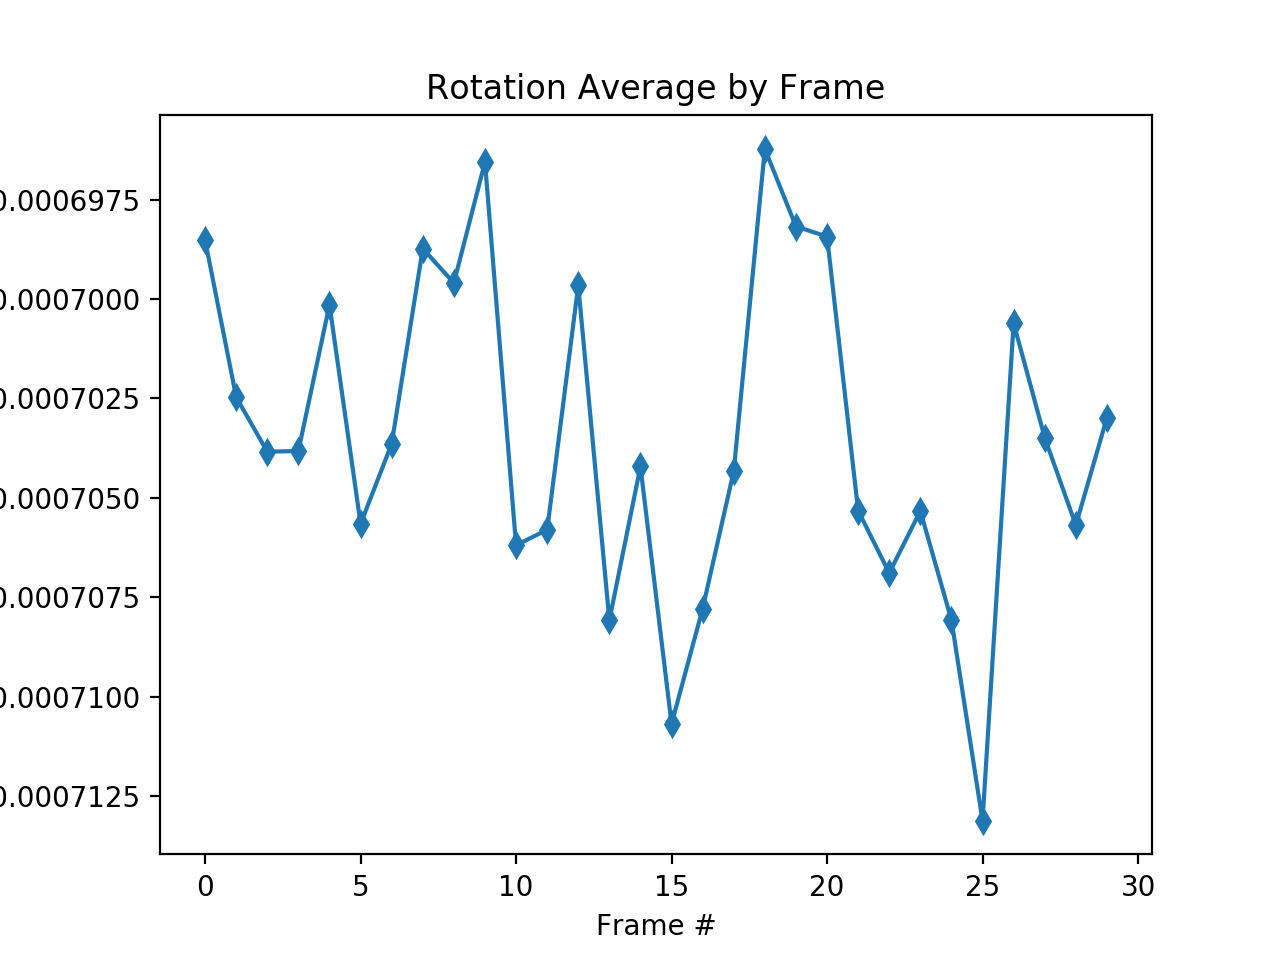

In [101]:

reload(visplot)
visplot.plotTransByFrame(fxFrameAv,fyFrameAv,peakFrameAv,sxAll,syAll,xdAll,ydAll,rotAll,prefix,inter)

In [102]:
#the average RMS for the whole set

print(rmsVal.mean())


0.0117849587921
